In [1]:
#import the necessary packages
import json
import string
import re
import nltk
nltk.download("stopwords")
from nltk.stem import WordNetLemmatizer
from nltk.corpus import wordnet
import pandas as pd
pd.options.mode.chained_assignment = None
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.linear_model import LinearRegression
from collections import Counter
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score

from nltk.corpus import stopwords
", ".join(stopwords.words('english'))
Stopwords = set(stopwords.words('english'))

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\user\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [2]:
#path to data 
train_path = "C:/Users/user/Desktop/ML_Challenge/train-1.json"
test_path = "C:/Users/user/Desktop/ML_Challenge/test.json"

In [3]:
#load the data
train_set = open(train_path)
test_set = open(test_path)
train = json.load(train_set)
test = json.load(test_set)

In [4]:
#convert to pandas Dataframe
df_train = pd.DataFrame(train)
df_test = pd.DataFrame(test)

In [5]:
#checking the dimensions of each dataset
print(df_train.shape, df_test.shape)

(9658, 11) (1000, 10)


In [6]:
#changing the order of each column of test set so it can match train set order
df_test = df_test.reindex(["doi", "title", "abstract", "authors", "venue", "year", "references",
                           "topics", "is_open_access", "fields_of_study"], axis=1)

### Handling Missing Values

In [7]:
#checking missing values in train data
df_train.isnull().sum()

doi                  0
title                0
abstract           159
authors              0
venue                0
year                 3
references           0
topics               0
is_open_access       0
fields_of_study    136
citations            0
dtype: int64

In [8]:
#dropping rows with missing values
df_train = df_train.dropna()

In [9]:
#checking train data information
df_train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 9381 entries, 0 to 9657
Data columns (total 11 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   doi              9381 non-null   object 
 1   title            9381 non-null   object 
 2   abstract         9381 non-null   object 
 3   authors          9381 non-null   object 
 4   venue            9381 non-null   object 
 5   year             9381 non-null   float64
 6   references       9381 non-null   int64  
 7   topics           9381 non-null   object 
 8   is_open_access   9381 non-null   bool   
 9   fields_of_study  9381 non-null   object 
 10  citations        9381 non-null   int64  
dtypes: bool(1), float64(1), int64(2), object(7)
memory usage: 815.3+ KB


In [10]:
#changing year to integer since it's a float
df_train["year"] = df_train["year"].astype('int64')

In [11]:
#taking fields_of_study, authors and topics out of list
df_train["fields_of_study"] = [",".join(i) for i in df_train["fields_of_study"]]
df_train["authors"] = [",".join(i) for i in df_train["authors"]]
df_train["topics"] = [",".join(i) for i in df_train["topics"]]

In [12]:
#checking missing values for test data
df_test.isnull().sum()

doi                 0
title               0
abstract           19
authors             0
venue               0
year                0
references          0
topics              0
is_open_access      0
fields_of_study    13
dtype: int64

In [13]:
#to presere each row in test data, we fill the missing values of fields of study with its mode and abstract with empty string
mode_fos = df_test["fields_of_study"].mode().values[0]
df_test["fields_of_study"] = df_test["fields_of_study"].apply(lambda d: d if isinstance(d, list) else mode_fos)
df_test["abstract"] = df_test["abstract"].fillna("")

In [14]:
#taking fields_of_study, authors and topics out of list for test data
df_test["fields_of_study"] = [",".join(i) for i in df_test["fields_of_study"]]
df_test["authors"] = [",".join(i) for i in df_test["authors"]]
df_test["topics"] = [",".join(i) for i in df_test["topics"]]

In [15]:
#checking test data information
df_test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 10 columns):
 #   Column           Non-Null Count  Dtype 
---  ------           --------------  ----- 
 0   doi              1000 non-null   object
 1   title            1000 non-null   object
 2   abstract         1000 non-null   object
 3   authors          1000 non-null   object
 4   venue            1000 non-null   object
 5   year             1000 non-null   int64 
 6   references       1000 non-null   int64 
 7   topics           1000 non-null   object
 8   is_open_access   1000 non-null   bool  
 9   fields_of_study  1000 non-null   object
dtypes: bool(1), int64(2), object(7)
memory usage: 71.4+ KB


### Exploratory Data Analysis
#### Here we will try find out how similar are train and test data by each column.

In [16]:
#function that takes a dataframe and a column from it and checks the duplicates
def duplicated_data(df, column):
    d = df.duplicated(subset=[column])
    return d.sum()

In [17]:
#using the function to check whether doi values are all unique in train and test data
print(duplicated_data(df_train, "doi"), "non-unique value")
print(duplicated_data(df_test, "doi"), "non-unique value")

1 non-unique value
0 non-unique value


In [18]:
#using the same function to check title column for both test and train datasets
print(duplicated_data(df_train, "title"), "non-unique value")
print(duplicated_data(df_test, "title"), "non-unique value") 

2 non-unique value
0 non-unique value


In [19]:
#using the same function to check abstract column for both test and train datasets
print(duplicated_data(df_train, "abstract"), "non-unique value")
print(duplicated_data(df_test, "abstract"), "non-unique value") 

5 non-unique value
18 non-unique value


In [20]:
#using the same function to check authors column for both test and train datasets
print(duplicated_data(df_train, "authors"), "non-unique value")
print(duplicated_data(df_test, "authors"), "non-unique value") 

450 non-unique value
10 non-unique value


#### For categorical data, we will check how many unique categories each column has both in train and test datasets

In [21]:
#function that takes dataframe and a column and returns the unique categories for that column
def categorical_check(column, df):
    return len(set(df[column]))

In [22]:
#checking the unique categories of venue for train and test datasets
print(categorical_check("venue", df_train), "unique categories in venue from the training set")
print(categorical_check("venue", df_test), "unique categories in venue from the testing set")

292 unique categories in venue from the training set
159 unique categories in venue from the testing set


In [23]:
#checking the unique categories of year for train and test datasets
print(categorical_check("year", df_train), "unique categories in year from the training set")
print(categorical_check("year", df_test), "unique categories in year from the testing set")

43 unique categories in year from the training set
37 unique categories in year from the testing set


In [24]:
#checking the unique categories of topics for train and test datasets
print(categorical_check("topics", df_train), "unique categories in topics from the training set")
print(categorical_check("topics", df_test), "unique categories in topics from the testing set")

7280 unique categories in topics from the training set
766 unique categories in topics from the testing set


In [25]:
#checking the unique categories of fields_of_study for train and test datasets
print(categorical_check("fields_of_study", df_train), "unique categories in fields_of_study from the training set")
print(categorical_check("fields_of_study", df_test), "unique categories in fields_of_study from the testing set")

53 unique categories in fields_of_study from the training set
25 unique categories in fields_of_study from the testing set


#### For numerical columns, we will find their range and the mean for both training and testing data, after which we will plot them.

In [26]:
#a function to find the range of and mean of a numerical column
def range_and_mean(column):
    min_val = min(column)
    max_val = max(column)
    
    m = column.mean()

    return (min_val, max_val), m

In [27]:
#use the function for references column in training dataset
range_and_mean(df_train["references"])

((0, 668), 32.53640336851082)

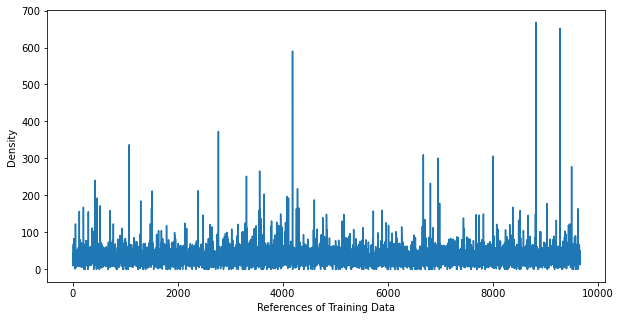

In [28]:
#plotting references of training data
plt.figure(figsize=(10,5))
plt.xlabel("References of Training Data")
plt.ylabel("Density")
df_train["references"].plot()
plt.show()

In [29]:
#use the function for references column in testing dataset
range_and_mean(df_test["references"])

((0, 304), 32.429)

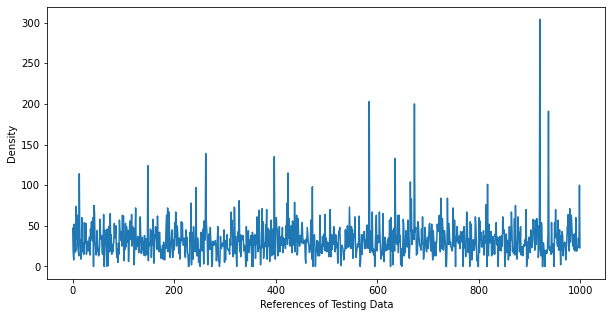

In [30]:
#plotting references for testing dataset
plt.figure(figsize=(10,5))
plt.xlabel("References of Testing Data")
plt.ylabel("Density")
df_test["references"].plot()
plt.show()

In [31]:
#let's check the citation range and mean in training dataset
range_and_mean(df_train["citations"])

((0, 9094), 37.94201044664748)

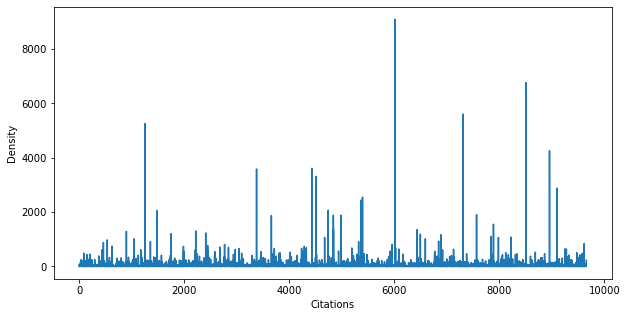

In [32]:
#plot the citations
plt.figure(figsize=(10,5))
plt.xlabel("Citations")
plt.ylabel("Density")
df_train["citations"].plot()
plt.show()

In [33]:
#checking the range and mean for year column in training data
range_and_mean(df_train["year"])

((1979, 2021), 2015.333439931777)

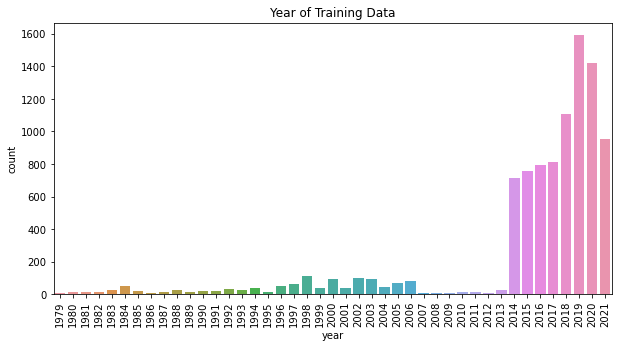

In [34]:
#plotting the year of training data
plt.figure(figsize=(10,5))
sns.countplot(x="year", data=df_train).set_title("Year of Training Data")
plt.xticks(rotation=90)
plt.show()

In [35]:
#checking the range and mean of year in testing data
range_and_mean(df_test["year"])

((1979, 2021), 2015.886)

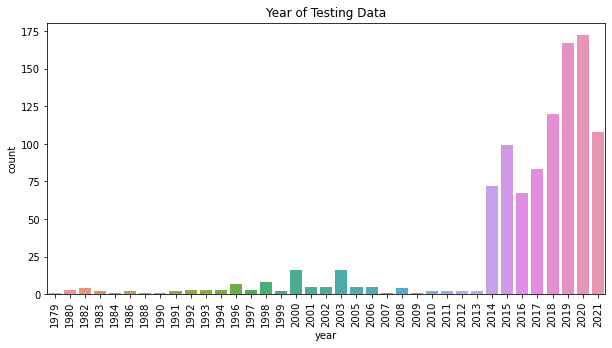

In [36]:
#plotting the year of test data
plt.figure(figsize=(10,5))
sns.countplot(x="year", data=df_test).set_title("Year of Testing Data")
plt.xticks(rotation=90)
plt.show()

#### For boolean columns, we will count them and plot

In [37]:
#checking is_open_access of training data
df_train["is_open_access"].value_counts()

True     7843
False    1538
Name: is_open_access, dtype: int64

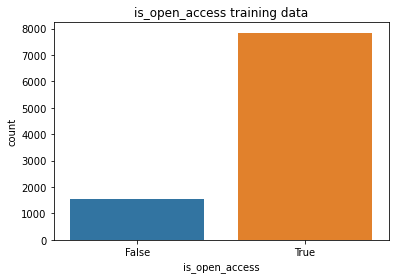

In [38]:
#plotting is_open_access of training data
sns.countplot(x="is_open_access", data=df_train).set_title("is_open_access training data")
plt.show()

In [39]:
#checking is_open_access of testing data
df_test["is_open_access"].value_counts()

True     829
False    171
Name: is_open_access, dtype: int64

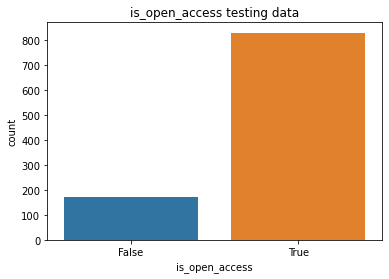

In [40]:
#plotting is_open_access of testing data
sns.countplot(x="is_open_access", data=df_test).set_title("is_open_access testing data")
plt.show()

### Removing Duplicates from Train Data

In [41]:
df_train.drop_duplicates(inplace=True)

In [42]:
df_train.drop_duplicates(subset=["title"], inplace=True)

In [43]:
df_train.drop_duplicates(subset=["abstract"], inplace=True)

In [44]:
df_train.shape

(9376, 11)

#### Removing rows with categories from train data that do not exist in test set

In [45]:
#a function that takes same columns from train set and test and return the resique of an intersection
def non_intersection(train_col,test_col):
    hold = []
    discard = []
    for i in train_col.unique():
        if i in test_col.unique():
            hold.append(i)
        else:
            discard.append(i)
    return discard

In [46]:
#use the function to remove from year column those categories that do not appear in test set
df_train = df_train[~df_train["year"].isin(non_intersection(df_train["year"], df_test["year"]))]

In [47]:
#use the function to remove from venue column those categories that do not appear in test set
df_train = df_train[~df_train["venue"].isin(non_intersection(df_train["venue"], df_test["venue"]))]

In [48]:
#use the function to remove from fields_of_study column those categories that do not appear in test set
df_train = df_train[~df_train["fields_of_study"].isin(non_intersection(df_train["fields_of_study"], 
                                                                       df_test["fields_of_study"]))]

In [49]:
df_train.shape

(8469, 11)

### Train and Test Data Transformation

In [50]:
#combine title and abstract into one column in train data
title_abstract = df_train["title"] + " " + df_train["abstract"]

In [51]:
#combine title and abstract into one column in test data
title_abs_test = df_test["title"] + " " + df_test["abstract"]

In [52]:
#insert the new column into desired positin in train set
df_train.insert(loc=3, column='title_abstract', value=title_abstract)

In [53]:
#insert the new column into desired positin in test set
df_test.insert(loc=3, column='title_abstract', value=title_abs_test)

In [54]:
#compute the age of the article in train set
article_age = [2021 - year for year in df_train["year"]]

In [55]:
#compute the age of the article in test set
article_age_test = [2021 - year for year in df_test["year"]]

In [56]:
#insert the age of article into desired positin in train set
df_train.insert(loc=7, column='age_of_article', value=article_age)

In [57]:
#insert the age of article into desired positin in test set
df_test.insert(loc=7, column='age_of_article', value=article_age_test)

In [58]:
#count the number of authors each paper has in train set
author_count = df_train['authors'].apply(lambda x: len(x.split(',')))

In [59]:
#count the number of authors each paper has in test set
author_count_test = df_test['authors'].apply(lambda x: len(x.split(',')))

In [60]:
#insert the count of authors into desired positin in train set
df_train.insert(loc=5, column='authors_count', value=author_count)

In [61]:
#insert the count of authors into desired positin in test set
df_test.insert(loc=5, column='authors_count', value=author_count_test)

In [62]:
#a function to clean text data
def pre_process_text(cols):
    
    #lowercase
    cols = cols.lower()
    
    #remove special characters and digits
    cols = re.sub("(\\d|\\W)+"," ", cols)
    
    return cols

In [63]:
#using the function, clean venue column in train set
df_train["venue"] = df_train["venue"].apply(lambda x: pre_process_text(x))

In [64]:
#using the function, clean venue column in test set
df_test["venue"] = df_test["venue"].apply(lambda x: pre_process_text(x))

In [65]:
#using the function, clean title_abstract column in train set
df_train["title_abstract"] = df_train["title_abstract"].apply(lambda x: pre_process_text(x))

In [66]:
#using the function, clean title_abstract column in test set
df_test["title_abstract"] = df_test["title_abstract"].apply(lambda x: pre_process_text(x))

In [67]:
#function for lemmatization 
lemmatizer = WordNetLemmatizer()
wordnet_map = {"N":wordnet.NOUN, "V":wordnet.VERB, "J":wordnet.ADJ, "R":wordnet.ADV}
def lemmatize_words(text):
    pos_tagged_text = nltk.pos_tag(text.split())
    return " ".join([lemmatizer.lemmatize(word, wordnet_map.get(pos[0], wordnet.NOUN)) for word, pos in pos_tagged_text])

In [68]:
#using the function, lemmatize title_abstract column in train set (will take a few minutes to run)
df_train["title_abstract"] = df_train["title_abstract"].apply(lambda text: lemmatize_words(text))

In [69]:
#using the function, lemmatize title_abstract column in test set (will take a few minutes to run)
df_test["title_abstract"] = df_test["title_abstract"].apply(lambda text: lemmatize_words(text))

In [70]:
#calculate the length of each title_abstract in train set
length = df_train["title_abstract"].str.len()

In [71]:
#calculate the length of each title_abstract in test set
length_test = df_test["title_abstract"].str.len()

In [72]:
#insert the length of abstract and title into desired positin in train set
df_train.insert(loc = 4, column = "length_of_abstract_title", value=length)

In [73]:
#insert the length of abstract and title into desired positin in test set
df_test.insert(loc = 4, column = "length_of_abstract_title", value=length_test)

#### Separate citations into variable y and combine train and test set into one dataframe

In [74]:
y = df_train["citations"]

In [75]:
len(y)

8469

In [76]:
df_train.drop("citations", axis=1, inplace=True)

In [77]:
combine_df = df_train.append(df_test, ignore_index=True)
combine_df.shape

(9469, 14)

In [78]:
#rank authors based on authors-count
authors_rank = combine_df['authors_count'].rank(pct= True, ascending = True)

In [79]:
#insert into desired position combined dataframe
combine_df.insert(loc=7, column='authors_rank', value=authors_rank)

In [80]:
#rank venues
venue_rank = combine_df['venue'].rank(pct=True, ascending = False)

In [81]:
#insert the ranking to the combined dataframe
combine_df.insert(loc=9, column='venue_rank', value=venue_rank)

In [82]:
#drop the unneccessary columns
combine_df.drop("title", axis=1, inplace=True)

In [83]:
combine_df.drop("abstract", axis=1, inplace=True)

In [84]:
combine_df.drop("authors", axis=1, inplace=True)

In [85]:
combine_df.drop("venue", axis=1, inplace=True)

In [86]:
combine_df.drop("year", axis=1, inplace=True)

In [87]:
combine_df.drop("topics", axis=1, inplace=True)

In [88]:
#get dummy codes for is_open_access and fields_of_study
combine_df = pd.get_dummies(data = combine_df, columns=["is_open_access", "fields_of_study"])

In [89]:
#add new stopwords to the existing list
newStopwords = ["two", "one", "make", "however", "also", "three", "like", "non", "although", "amr", "et", "al", "pre", "conll",
               "crf", "co", "back", "take", "bleu","wmt", "nmt", "seq", "within", "may", "often", "know", "many", "step", "sub",
                "mt", "via", "po", "ner", "cue", "able", "early", "among", "due", "either", "even", "though", "yet", "bert", "qa",
               "start", "could", "come", "little", "look", "add", "thus", "basis", "de", "along", "http", "four", "must", "easy",
               "inter", "th", "five", "smt", "semi", "get", "ii", "kg", "hate", "without", "zero", "hop", "would", "whose", "whether",]
updated_stopwords = Stopwords.union(newStopwords)

In [90]:
#put title_abstract into a list
into_list = combine_df["title_abstract"].tolist()

In [91]:
#apply countvectorizer and take top 500 words
cv = CountVectorizer(max_df=0.85, stop_words = updated_stopwords, max_features = 500)
word_counts = cv.fit_transform(into_list)

In [92]:
#do tfidf on the 500 words
tfidf= TfidfTransformer(smooth_idf=True, use_idf=True)
vectorized = tfidf.fit_transform(word_counts)

In [93]:
#convert the result to pandas dataframe
result = pd.DataFrame(vectorized.toarray(), columns=cv.get_feature_names())

In [94]:
#drop the old title_abstract column
combine_df.drop("title_abstract", axis=1, inplace=True)

In [95]:
#make sure the indexes are same for two dataframes before concatinating 
combine_df.index = result.index

In [96]:
#concat dataframes
all_data = pd.concat([combine_df, result], axis=1)

In [97]:
#split the combined dataset back into its original form
train = all_data.loc[:8468,:]

In [98]:
test = all_data.loc[8469:, :]

In [99]:
y.shape

(8469,)

In [100]:
train.shape

(8469, 534)

In [101]:
test.shape

(1000, 534)

In [102]:
#preserve testing data doi
doi = pd.DataFrame(test.iloc[: , 0])

In [103]:
X = train.iloc[:, 1:]

In [104]:
X_test = test.iloc[:, 1:]

In [105]:
#split the train data into training and validation set
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size = 0.20, random_state = 0)

In [106]:
#scale the datasets
scaler = StandardScaler()

X_train = scaler.fit_transform(X_train)
X_val = scaler.transform(X_val)
X_test = scaler.transform(X_test)